# 1. Objective 

Handling non-linearity using additive modeling

# 2. LOESS smoothers

Sort of a piece-wise linear model applied to subsets of the data controlled by the argument `span`.

## 2.1. Bioluminescence

In [4]:
data_df = read.delim("data/ISIT.txt")

In [5]:
glimpse(data_df)

Observations: 789
Variables: 14
$ SampleDepth   <dbl> 517, 582, 547, 614, 1068, 1005, 1036, 1100, 1490, 1520,…
$ Sources       <dbl> 28.73, 27.90, 23.44, 18.33, 12.38, 11.23, 11.06, 10.57,…
$ Station       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ Time          <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…
$ Latitude      <dbl> 50.1508, 50.1508, 50.1508, 50.1508, 50.1508, 50.1508, 5…
$ Longitude     <dbl> -14.4792, -14.4792, -14.4792, -14.4792, -14.4792, -14.4…
$ Xkm           <dbl> -34.106, -34.106, -34.106, -34.106, -34.106, -34.106, -…
$ Ykm           <dbl> 16.779, 16.779, 16.779, 16.779, 16.779, 16.779, 16.779,…
$ Month         <int> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4…
$ Year          <int> 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2…
$ BottomDepth   <int> 3939, 3939, 3939, 3939, 3939, 3939, 3939, 3939, 3939, 3…
$ Season        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ Discovery     <int

In [6]:
sources16 = data_df %>% filter(Station == 16) %>% pull(Sources)
depth16 = data_df %>% filter(Station == 16) %>% pull(SampleDepth)

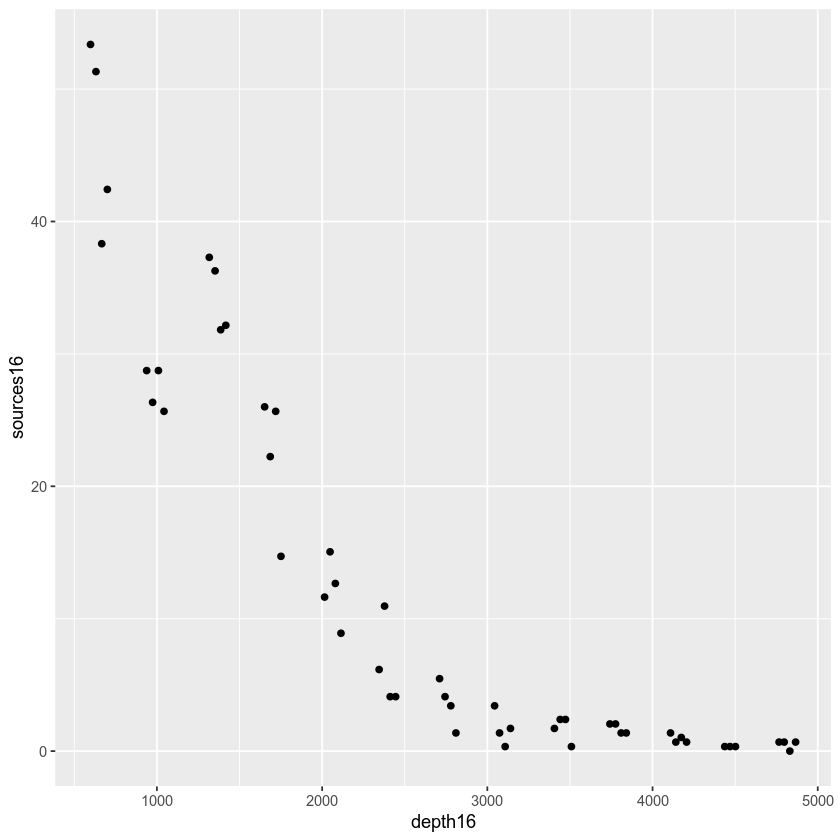

In [12]:
qplot(depth16, sources16)

In [7]:
lum_gam1 = gam::gam(sources16 ~ lo(depth16, span = 0.5))
AIC(lum_gam1)

Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

[1] 296.3008

In applying the smoother, we need to make a choice on the span, i.e., how much proportion of the data is seen by the model. This can be estimated using a hyperparameter exploration approach with AIC as the criterion.

In [8]:
span_values = c(0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0)

In [9]:
best_span_value = min(span_values)

for (span_value in span_values) {
    AIC_best_span = AIC(gam::gam(sources16 ~ lo(depth16, span = best_span_value)))
    AIC_current_span = AIC(gam::gam(sources16 ~ lo(depth16, span = span_value)))
    
    if (AIC_current_span < AIC_best_span) best_span_value = span_value
}

Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”Warning message in model.matri

In [10]:
best_span_value

[1] 0.15

In [11]:
AIC_best_span

[1] 244.8716

In [12]:
summary(gam::gam(sources16 ~ lo(depth16, span=best_span_value)))

Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”


Call: gam::gam(formula = sources16 ~ lo(depth16, span = best_span_value))
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-6.60702 -0.81706 -0.06645  0.63791  4.82165 

(Dispersion Parameter for gaussian family taken to be 5.3625)

    Null Deviance: 11515.03 on 50 degrees of freedom
Residual Deviance: 190.6976 on 35.5611 degrees of freedom
AIC: 244.8716 

Number of Local Scoring Iterations: 2 

Anova for Parametric Effects
                                        Df Sum Sq Mean Sq F value    Pr(>F)    
lo(depth16, span = best_span_value)  1.000 8705.4  8705.4  1623.4 < 2.2e-16 ***
Residuals                           35.561  190.7     5.4                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Anova for Nonparametric Effects
                                    Npar Df Npar F     Pr(F)    
(Intercept)                                                     
lo(depth16, span = best_span_value)    13.4 36.341 < 2.2e-16 ***
---
Signif. codes:

# 3. Splines

## 3.1. Univariate splines

Use a cubic regression spline to smooth the line, find the optimal parameters by cross-validation. This means that `X` is divided into a certain number of intervals and in each interval a cubic polynomial is fit. Fitted values per interval are glued together to form the smoothing curve. Each "join-together" point is called a knot. 

A general recommendation is to use 3 knots for less than 30 observations and 5 knots for more than 100.

However, it is not the knots we are interested but the overall "smoothener". More than the knots it is the shape of the curve that determines the ideality of fit. This is done by imposing a penalizer on the second derivative of the smoother. This ensures that over-smoothing is avoided.

In [13]:
lum_gam2 = mgcv::gam(sources16 ~ s(depth16, fx=FALSE, k=-1, bs="cr"))

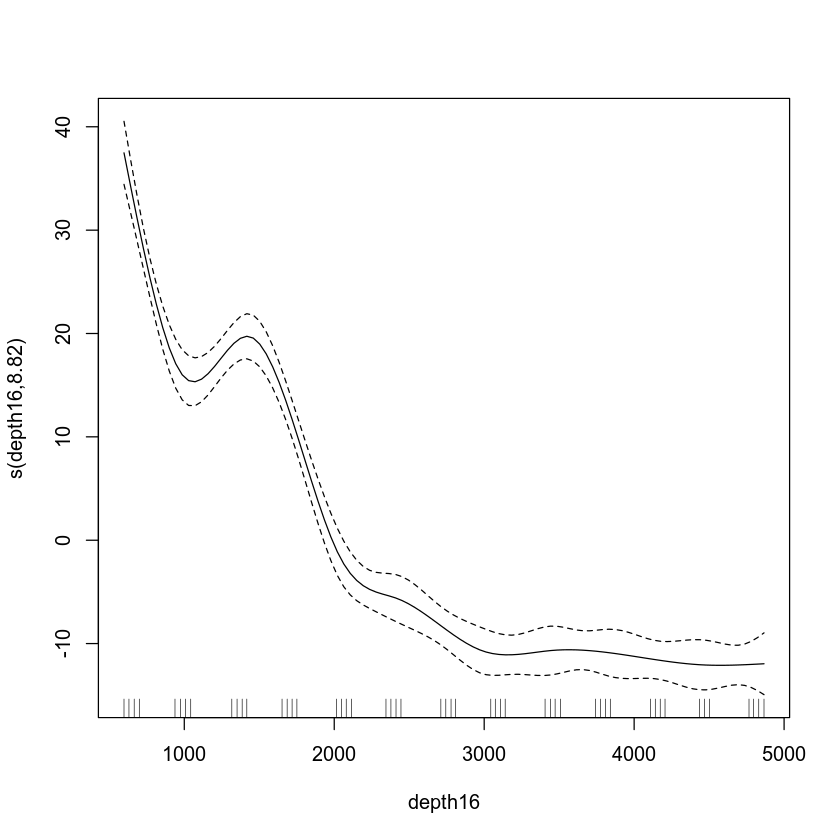

In [14]:
plot(lum_gam2)

In [15]:
summary(lum_gam2)


Family: gaussian 
Link function: identity 

Formula:
sources16 ~ s(depth16, fx = FALSE, k = -1, bs = "cr")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  12.4771     0.3711   33.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df     F p-value    
s(depth16) 8.817   8.99 177.7  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.97   Deviance explained = 97.5%
GCV = 8.6978  Scale est. = 7.0236    n = 51

Let us see how the penalization works in action. More penalty implies more linearity in fit.

In [16]:
sources19 = data_df %>% filter(Station == 19) %>% pull(Sources)
depth19 = data_df %>% filter(Station == 19) %>% pull(SampleDepth)

depth19 = depth19 - min(depth19)
depth19 = depth19/max(depth19)
I = order(depth19)

depth19 = depth19[I]
sources19 = sources19[I]

In [17]:
rk = function(x,z){
((z-0.5)^2-1/12)*((x-0.5)^2-1/12)/4 -((abs(x-z)-0.5)^4 -0.5*(abs(x-z)-0.5)^2 +7/240)/24
}

spl_X = function(x,xk){
    q = length(xk)+2
    n = length(x)
    X = matrix(1,n,q)
    X[,2]  = x
    X[,3:q] = outer(x,xk,FUN=rk)
    return(X)
}

spl_S = function(xk){
  q = length(xk)+2
  S = matrix(0,q,q)
  S[3:q,3:q] = outer(xk,xk,FUN=rk)
  return(S)
}

mat_sqrt<-function(S){
  d = eigen(S,symmetric=TRUE)
  d$values[d$values<0] = 0
  rS = d$vectors%*%diag(d$values^0.5)%*%t(d$vectors)
  return(rS)
}

In [18]:
prs_fit = function(y, x, xk, lambda){
    print(lambda)
    q  = length(xk)+2
    n = length(x)
    Xa = rbind(spl_X(x,xk), mat_sqrt(spl_S(xk))*sqrt(lambda))
    y[(n+1):(n+q)]<-0
    return(lm(y~Xa-1))
}

In [19]:
xk = 1:7/8
xp = 1:100/100


lambda = 1e-6


#Graph showing the effect of lambda

YALL  = vector(length=100*8)
XALL = vector(length=100*8)
IDALL = vector(length=100*8)

a1 = 1
a2 = 100
lambda = 10e-7

for (i in 1:8){
  a1
  mod2 = prs_fit(sources19, depth19, xk, lambda)
  Xp = spl_X(xp, xk)
  YALL[a1:a2] = Xp%*%coef(mod2)
  XALL[a1:a2] = xp
  IDALL[a1:a2] = rep(lambda,100)
  a1 = a1+100
  a2 = a2+100
  lambda = lambda*10
}

[1] 1e-06
[1] 1e-05
[1] 1e-04
[1] 0.001
[1] 0.01
[1] 0.1
[1] 1
[1] 10


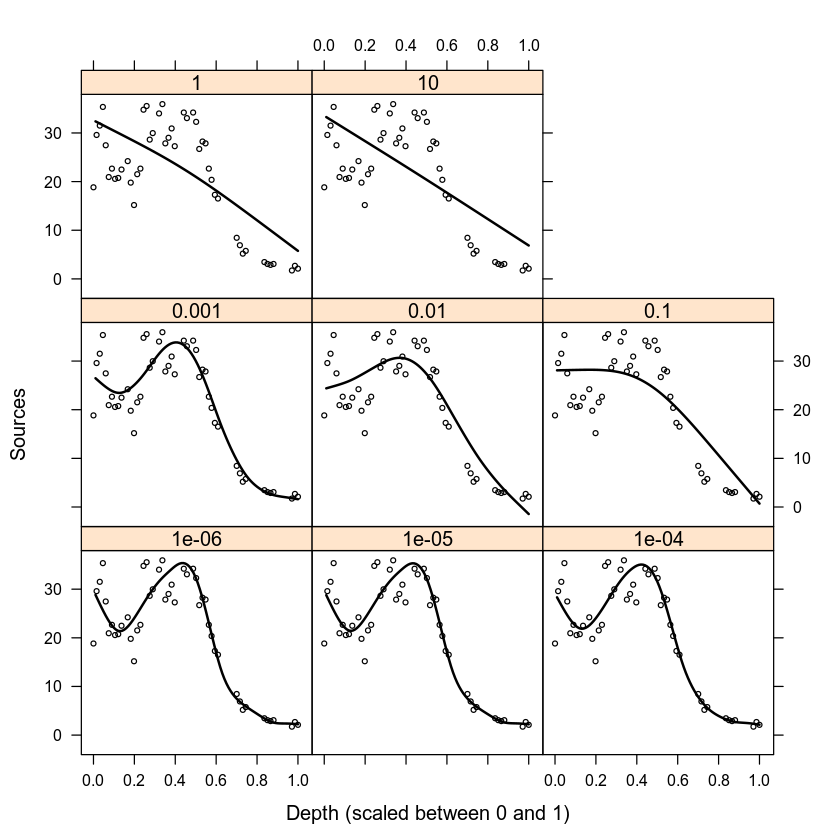

In [20]:
xyplot(YALL~XALL|factor(IDALL),type="l",col=1,xlab="Depth (scaled between 0 and 1)",
       ylab="Sources",a1=1,
       panel=function(x,y,subscripts,...){
        panel.lines(x,y,col=1,lwd=2)
        panel.points(depth19, sources19, col=1, cex=0.5)}
        )

## 3.2. Multivariate splines

In [6]:
data_df %>%
    filter(Station == 8 | Station == 13) %>%
    select(Sources, Station, SampleDepth) ->
    subset_df

In [7]:
glimpse(subset_df)

Observations: 90
Variables: 3
$ Sources     <dbl> 39.43, 37.91, 35.93, 35.78, 35.78, 33.49, 32.28, 30.60, 3…
$ Station     <int> 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, …
$ SampleDepth <dbl> 1417, 1167, 1452, 1276, 1521, 1132, 1203, 1487, 1658, 123…


In [12]:
subset_df %>%
    group_by(Station) %>%
    summarize(min_depth = min(SampleDepth),
              max_depth = max(SampleDepth)) %>%
    ungroup() %>%
    summarize(min_depth = max(min_depth),
              max_depth = min(max_depth)) ->
    ends_to_clip_df

In [13]:
subset_df %>%
    filter(SampleDepth > ends_to_clip_df$min_depth, SampleDepth < ends_to_clip_df$max_depth) ->
    filtered_df

In [14]:
glimpse(filtered_df)

Observations: 75
Variables: 3
$ Sources     <dbl> 39.43, 37.91, 35.93, 35.78, 35.78, 33.49, 32.28, 30.60, 3…
$ Station     <int> 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, …
$ SampleDepth <dbl> 1417, 1167, 1452, 1276, 1521, 1132, 1203, 1487, 1658, 123…


In [15]:
multivar_gam1 = mgcv::gam(Sources ~ s(SampleDepth) + factor(Station),
                          data = filtered_df)

In [16]:
summary(multivar_gam1)


Family: gaussian 
Link function: identity 

Formula:
Sources ~ s(SampleDepth) + factor(Station)

Parametric coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         19.198      1.054  18.207  < 2e-16 ***
factor(Station)13  -12.296      1.397  -8.801 7.59e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df     F  p-value    
s(SampleDepth) 4.849  5.904 14.77 7.08e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.695   Deviance explained = 71.9%
GCV = 38.802  Scale est. = 35.259    n = 75

In [17]:
anova(multivar_gam1)


Family: gaussian 
Link function: identity 

Formula:
Sources ~ s(SampleDepth) + factor(Station)

Parametric Terms:
                df     F  p-value
factor(Station)  1 77.46 7.59e-13

Approximate significance of smooth terms:
                 edf Ref.df     F  p-value
s(SampleDepth) 4.849  5.904 14.77 7.08e-12

The estimate of the scale parameter gives us the variance of the residuals.

In [18]:
sqrt(35.259)

[1] 5.937929

Formally, $Sources_i = 19.2 + s(Depth_i) + Station_i + \epsilon_i$, $\epsilon_i \sim N(0, 5.94^2)$


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 6 iterations.
The RMS GCV score gradient at convergence was 0.0005521159 .
The Hessian was positive definite.
Model rank =  11 / 11 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                 k'  edf k-index p-value
s(SampleDepth) 9.00 4.85    1.42    0.99


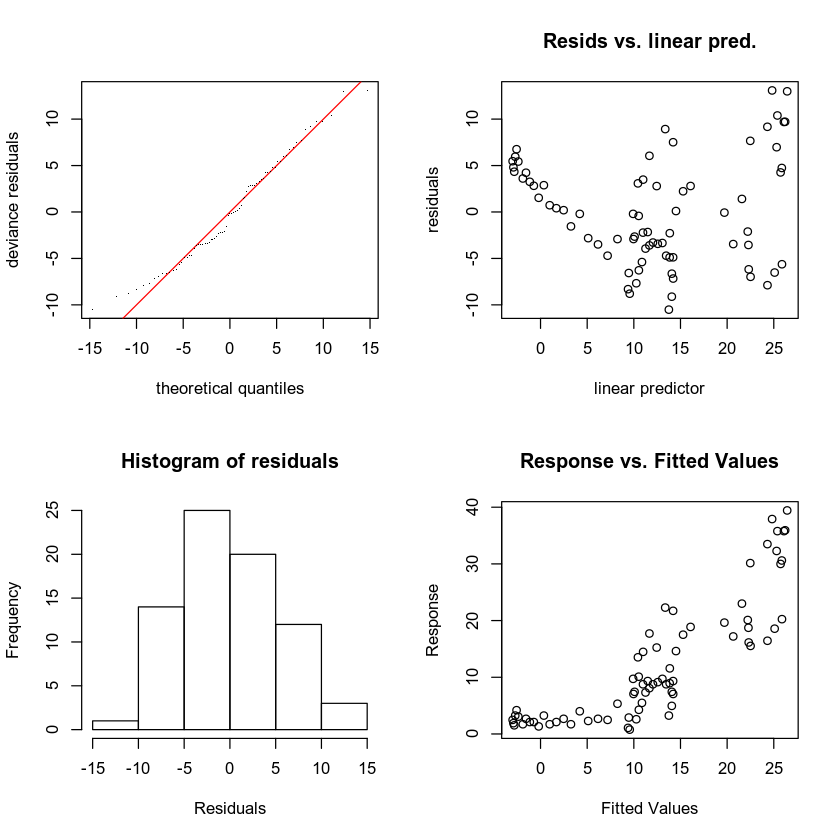

In [19]:
gam.check(multivar_gam1)

There seems to be a pattern in the residuals even though the Q-Q plot and the histogram look okay.

In [20]:
multivar_gam2 = mgcv::gam(Sources ~ s(SampleDepth) + 
                                    s(SampleDepth, by = as.numeric(Station ==  13)) + 
                                    factor(Station),
                          data = filtered_df)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 8 iterations.
The RMS GCV score gradient at convergence was 8.054535e-05 .
The Hessian was positive definite.
Model rank =  20 / 21 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                                            k'   edf k-index p-value
s(SampleDepth)                            9.00  8.07     1.1    0.73
s(SampleDepth):as.numeric(Station == 13) 10.00  7.20     1.1    0.82


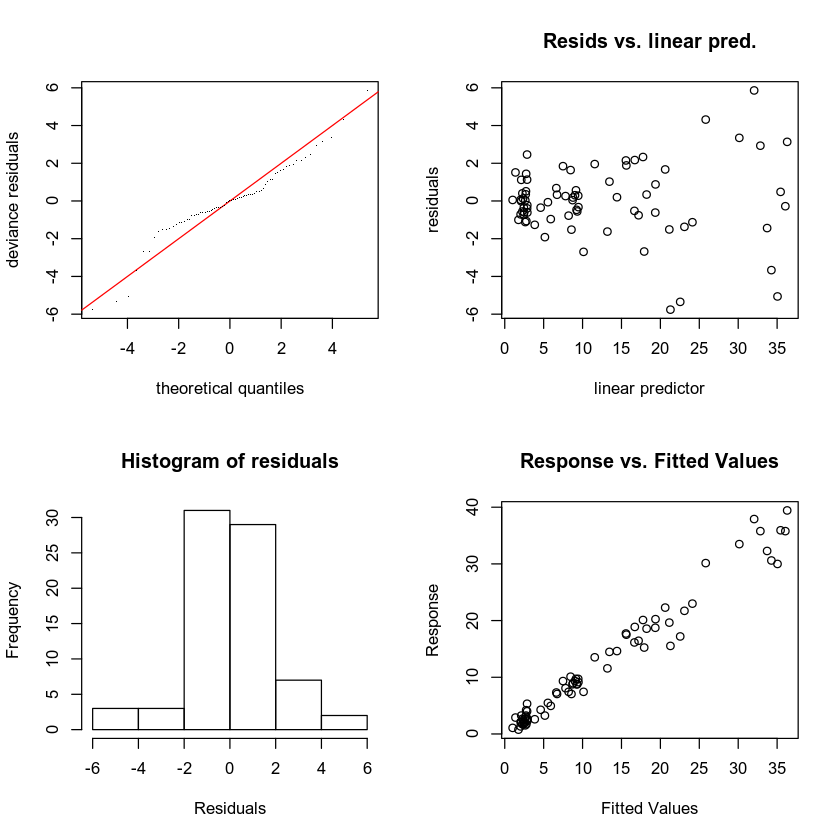

In [23]:
gam.check(multivar_gam2)

In [22]:
anova(multivar_gam2)


Family: gaussian 
Link function: identity 

Formula:
Sources ~ s(SampleDepth) + s(SampleDepth, by = as.numeric(Station == 
    13)) + factor(Station)

Parametric Terms:
                df     F p-value
factor(Station)  1 2.374   0.129

Approximate significance of smooth terms:
                                           edf Ref.df      F p-value
s(SampleDepth)                           8.073  8.608 101.88  <2e-16
s(SampleDepth):as.numeric(Station == 13) 7.196  8.163  52.93  <2e-16

In [24]:
AIC(multivar_gam1); AIC(multivar_gam2)

[1] 488.5602

[1] 345.2614

In [25]:
summary(multivar_gam2)


Family: gaussian 
Link function: identity 

Formula:
Sources ~ s(SampleDepth) + s(SampleDepth, by = as.numeric(Station == 
    13)) + factor(Station)

Parametric coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        18.8552     0.3879  48.605   <2e-16 ***
factor(Station)13  -8.3931     5.4471  -1.541    0.129    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                           edf Ref.df      F p-value    
s(SampleDepth)                           8.073  8.608 101.88  <2e-16 ***
s(SampleDepth):as.numeric(Station == 13) 7.196  8.163  52.93  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Rank: 20/21
R-sq.(adj) =  0.959   Deviance explained = 96.8%
GCV =  6.037  Scale est. = 4.6872    n = 75

In [26]:
anova(multivar_gam1, multivar_gam2, test = "F")

Resid. Df,Resid. Dev,Df,Deviance,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
67.09585,2402.9048,NA,NA,NA,NA
56.72931,272.9408,10.36654,2129.964,43.83529,2.794909e-23


There is an alternate way of specifying the same GAM.

In [27]:
multivar_gam3 = mgcv::gam(Sources ~ s(SampleDepth, by = as.numeric(Station == 8)) +
                                    s(SampleDepth, by = as.numeric(Station == 13)) +
                                    factor(Station),
                          data = filtered_df)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 11 iterations.
The RMS GCV score gradient at convergence was 0.0002258347 .
The Hessian was positive definite.
Model rank =  20 / 22 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                                            k'   edf k-index p-value
s(SampleDepth):as.numeric(Station == 8)  10.00  8.18    1.08    0.74
s(SampleDepth):as.numeric(Station == 13) 10.00  6.92    1.08    0.69


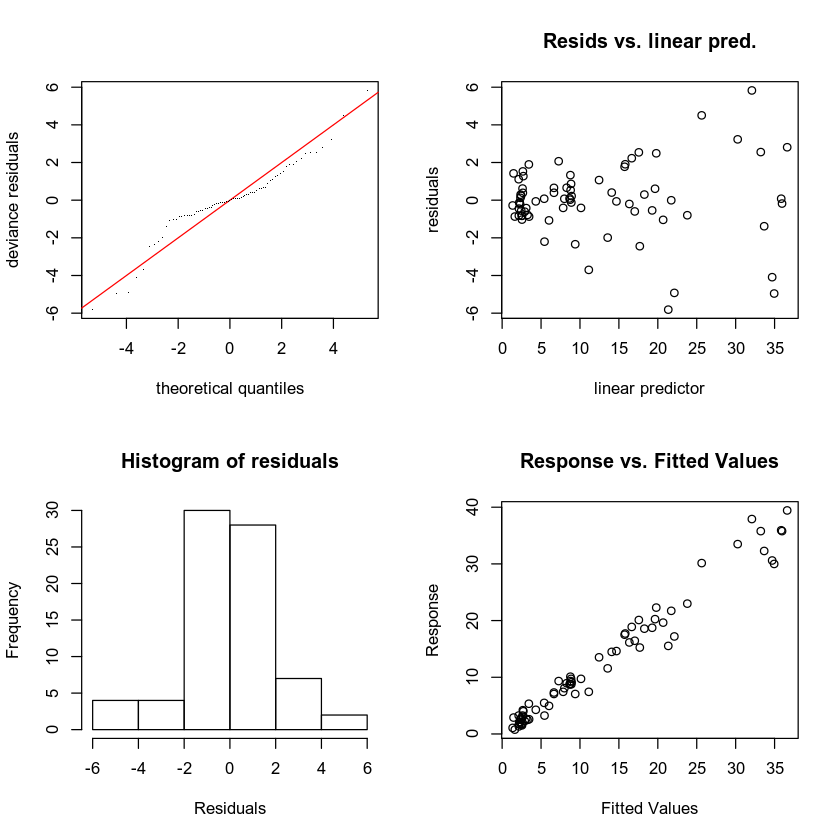

In [28]:
gam.check(multivar_gam3)

# 3.3. GAM with collinearity

GAM's run into serious problems if we have collinear predictors

In [29]:
data_df = read.delim("data/Vegetation.txt")

In [30]:
glimpse(data_df)

Observations: 105
Variables: 9
$ SAMPLEYR <int> 1958, 1962, 1967, 1974, 1981, 1989, 1994, 2002, 1958, 1962, …
$ Time     <int> 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 4, …
$ Transect <int> 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, …
$ Richness <int> 8, 6, 8, 8, 10, NA, 7, 6, 5, 8, 6, 6, 6, NA, 6, 6, 7, 10, 8,…
$ ROCK     <dbl> 27.0, 26.0, 30.0, 18.0, 23.0, NA, 26.0, 39.0, 25.0, 24.0, 21…
$ LITTER   <dbl> 30.0, 20.0, 24.0, 35.0, 22.0, NA, 26.0, 19.0, 26.0, 24.0, 16…
$ BARESOIL <dbl> 26.0, 28.0, 30.0, 16.0, 9.0, NA, 23.0, 19.0, 33.0, 29.0, 41.…
$ FallPrec <dbl> 30.22, 99.56, 43.43, 54.86, 24.38, NA, 10.16, 34.29, 30.22, …
$ SprTmax  <dbl> 15.77, 15.21, 12.76, 14.00, 14.33, NA, 16.91, 13.86, 15.79, …


In [31]:
multivar_gam4 = mgcv::gam(Richness ~ s(ROCK, bs="cs") + 
                                     s(LITTER, bs="cs") + 
                                     s(BARESOIL, bs="cs") + 
                                     s(FallPrec, bs="cs") + 
                                     s(SprTmax, bs="cs"),
                          data = data_df)

In [32]:
anova(multivar_gam4)


Family: gaussian 
Link function: identity 

Formula:
Richness ~ s(ROCK, bs = "cs") + s(LITTER, bs = "cs") + s(BARESOIL, 
    bs = "cs") + s(FallPrec, bs = "cs") + s(SprTmax, bs = "cs")

Approximate significance of smooth terms:
              edf Ref.df     F  p-value
s(ROCK)     1.722  9.000 1.396 0.000602
s(LITTER)   1.821  9.000 0.601 0.038134
s(BARESOIL) 4.116  9.000 2.296 0.000694
s(FallPrec) 4.680  9.000 1.597 0.010168
s(SprTmax)  5.023  9.000 2.512 0.000602


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 13 iterations.
The RMS GCV score gradient at convergence was 7.709408e-07 .
The Hessian was positive definite.
Model rank =  46 / 46 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

              k'  edf k-index p-value
s(ROCK)     9.00 1.72    1.02    0.51
s(LITTER)   9.00 1.82    1.33    1.00
s(BARESOIL) 9.00 4.12    1.21    0.91
s(FallPrec) 9.00 4.68    1.13    0.77
s(SprTmax)  9.00 5.02    1.05    0.52


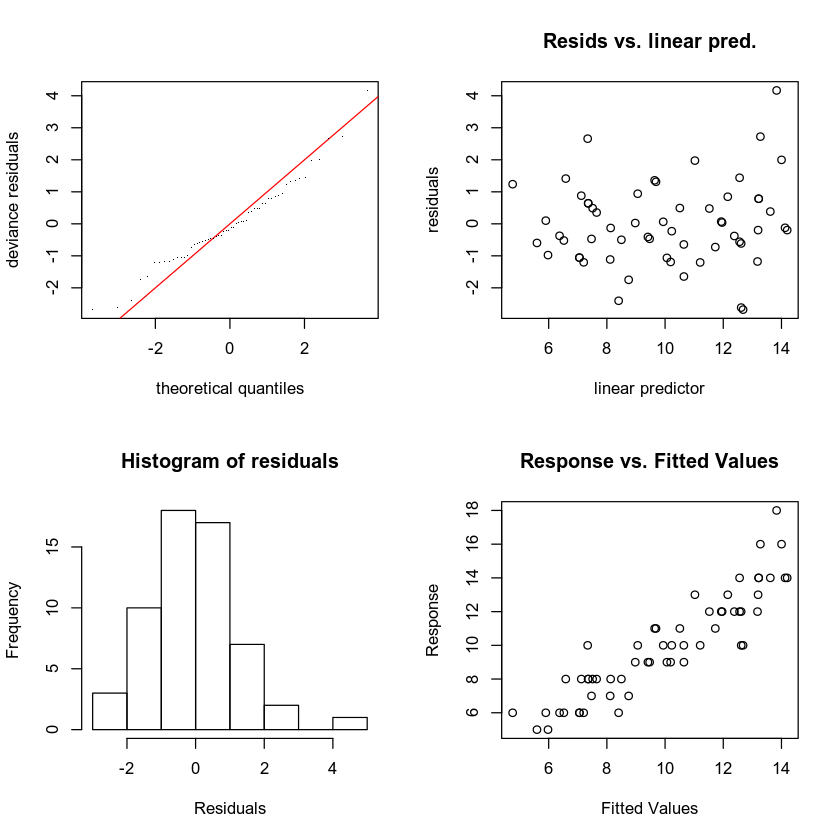

In [33]:
gam.check(multivar_gam4)

# R environment

In [1]:
library(tidyverse)
library(gam)
library(mgcv)
library(lattice)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: splines
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded gam 1.16.1

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.8-29. For overview type 'hel

In [2]:
setwd("~/mixed-effects-models")

In [3]:
print(sessionInfo())

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lattice_0.20-38 mgcv_1.8-29     nlme_3.1-141    gam_1.16.1     
 [5] foreach_1.4.4   forcats_0.4.0   stringr_1.4.0   dplyr_0.8.0.1  
 [9] purrr_0.3.2     readr_1.3.1     tidyr_0.8.3     tibble_2.1.1   
[13] ggplot2_3.1.1   tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3        t